In [1]:
import cPickle

# Plotting stuff
import matplotlib
# For a while I could only prevent GTK loading by using matlab in PDF mode
# but apparently we could get away with just setting inline
# matplotlib.use("Pdf")
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from blocks.extensions.saveload import load

Using gpu device 1: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
rnn_type = 'lstm'

ml = load(open("seqgen_" + rnn_type + ".pkl"))
rnn_sample = ml.model.get_theano_function()

param_dict = ml.model.get_parameter_dict()

char_to_ind = cPickle.load(open("char_to_ind.pkl"))

In [3]:
def get_model_var(layer_n, var_type):
#     value_type can either be "state" or "cells"
    cg_path_tpl = "/sequencegenerator/with_fake_attention/transition/layer#{0}.initial_{1}"
    return param_dict[cg_path_tpl.format(layer_n, var_type)]

In [4]:
def lstm_reads(chr_seq):
    
    init_state0 = get_model_var(0, 'state')
    init_state1 = get_model_var(1, 'state')
    init_state2 = get_model_var(2, 'state')
    init_cells0 = get_model_var(0, 'cells')
    init_cells1 = get_model_var(1, 'cells')
    init_cells2 = get_model_var(2, 'cells')
    
    chr_ids = [char_to_ind[char] for char in chr_seq]
    memory_cells = []
    for chr_id in chr_ids:
        new_state0, new_cells0, new_state1, new_cells1, new_state2, new_cells2, current_char, cost = rnn_sample([[chr_id]])
        init_state0.set_value(new_state0[0][0])
        init_state1.set_value(new_state1[0][0])
        init_state2.set_value(new_state2[0][0])
        init_cells0.set_value(new_cells0[0][0])
        init_cells1.set_value(new_cells1[0][0])
        init_cells2.set_value(new_cells2[0][0])
        vals = init_cells2.get_value()
        memory_cells.append(vals)
    
    return (np.column_stack(memory_cells), np.array(chr_ids))
        

## Going through character sequence

In [5]:
cats = lstm_reads('cats')

### Plotting Stuff...

This for now is just a demo of how easy it is to get at the various components of an NN and plot them

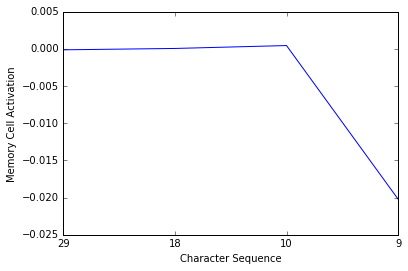

In [19]:
# ranges from 0 to len(input_char_seq) - 1
input_positions = np.arange(len(cats[1])) 
plt.plot(input_positions, cats[0][6])
plt.ylabel("Memory Cell Activation")
plt.xlabel("Character Sequence")
# sets char IDs as tick labels on the X axis
plt.xticks(input_positions, cats[1])
plt.show()